## Random search compression on LeNet-5

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.rnd import RandomController
from utils.train import *
from utils.weight_sharing import *
from utils.plot import *

Setting some global parameters 

In [2]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH = './models/lenet/saves/lenet.save'

ACC_MULTIPLIER = 4
CR_MULTIPLIER = 1

NUM_INDIVIDUALS = 2

SAVE_RND_FILE = './results/test_RND_save.csv'
SAVE_EVERY = 1

RANGE_OPTIMIZATION = True

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
share_order = [0, 1, 2, 3, 4]
retrain_amount = [0, 0, 0, 0, 0]

def fitness_fc(share):
    # reset the net
    get_trained(model, NET_PATH, train_settings)
    for layer in ws_controller.model_layers:
        layer.weight.requires_grad = True
    
    # share weigts by particle

    share.data = ws_controller.share(share.representation, share_order, retrain_amount)

    if share.data['accuracy'] <= 0.95:
        return share.data['accuracy']

    return 1 / math.sqrt(pow(1 - ((share.data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (share.data['compression']/14), 2))

In [6]:
data = {
    'fitness': [],
    'representation': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

rnd_data = pd.read_csv(SAVE_RND_FILE).astype(data_types) if os.path.exists(SAVE_RND_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(rnd_controler:RandomController):
    global rnd_data

    new_data = copy.deepcopy(data)

    indiv = rnd_controler.current_indiv

    new_data['fitness'].append(indiv.fitness)
    new_data['representation'].append(indiv.representation)
    new_data['accuracy'].append(indiv.data['accuracy'])
    new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
    new_data['compression'].append(indiv.data['compression'])
    new_data['share_t'].append(indiv.data['times']['share'])
    new_data['train_t'].append(indiv.data['times']['train'])
    new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    rnd_data = rnd_data.append(pd.DataFrame(new_data).astype(data_types))
    rnd_data.reset_index(drop=True, inplace=True)
    os.makedirs(os.path.dirname(SAVE_RND_FILE), exist_ok=True)
    rnd_data.to_csv(SAVE_RND_FILE, index=False)

Setting ranges with optimization

In [7]:
repr_ranges = [range(1, 21), range(1, 21), range(1, 21), range(1, 21), range(1, 21)]

lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    repr_ranges = ws_controller.get_optimized_layer_ranges(repr_ranges, lam_test_inp, 0.97, savefile='./results/lenet-layer-perf.csv')

repr_ranges

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

Running the search

In [8]:
random = RandomController(repr_ranges, fitness_fc)

random.run(NUM_INDIVIDUALS, logger_fc, verbose = True)

Individual 1/2 (1) evaluated Individual ([20, 12, 6, 6, 9]) fit:2.098998962333233
Individual 2/2 (2) evaluated Individual ([12, 15, 16, 15, 17]) fit:1.828590631214908


[20, 12, 6, 6, 9]

See output

In [9]:
rnd_data

,fitness,representation,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,6.079699,"[7, 5, 6, 8, 10]",0.9664,0.0182,9.153156,0.798984,0.0,4.615602
1,5.968797,"[15, 5, 11, 11, 6]",0.9700,0.0146,8.075193,0.693913,0.0,3.887215
2,6.076025,"[4, 18, 8, 16, 15]",0.9840,0.0006,8.499650,0.598233,0.0,3.584366
3,5.944353,"[16, 10, 14, 10, 5]",0.9812,0.0034,7.534952,0.681499,0.0,3.532139
4,5.845550,"[20, 11, 11, 15, 13]",0.9836,0.0010,6.760860,0.672391,0.0,3.610518
...,...,...,...,...,...,...,...,...
401,5.747569,"[19, 17, 15, 17, 12]",0.9826,0.0020,6.154407,0.756580,0.0,3.455132
402,5.805272,"[17, 20, 14, 10, 11]",0.9828,0.0018,6.514770,0.774980,0.0,3.456193
403,5.825832,"[13, 8, 19, 20, 19]",0.9852,-0.0006,6.586564,0.821187,0.0,3.516259
404,2.098999,"[20, 12, 6, 6, 9]",0.9810,0.0036,7.883527,0.560417,0.0,3.787137


Plotting data

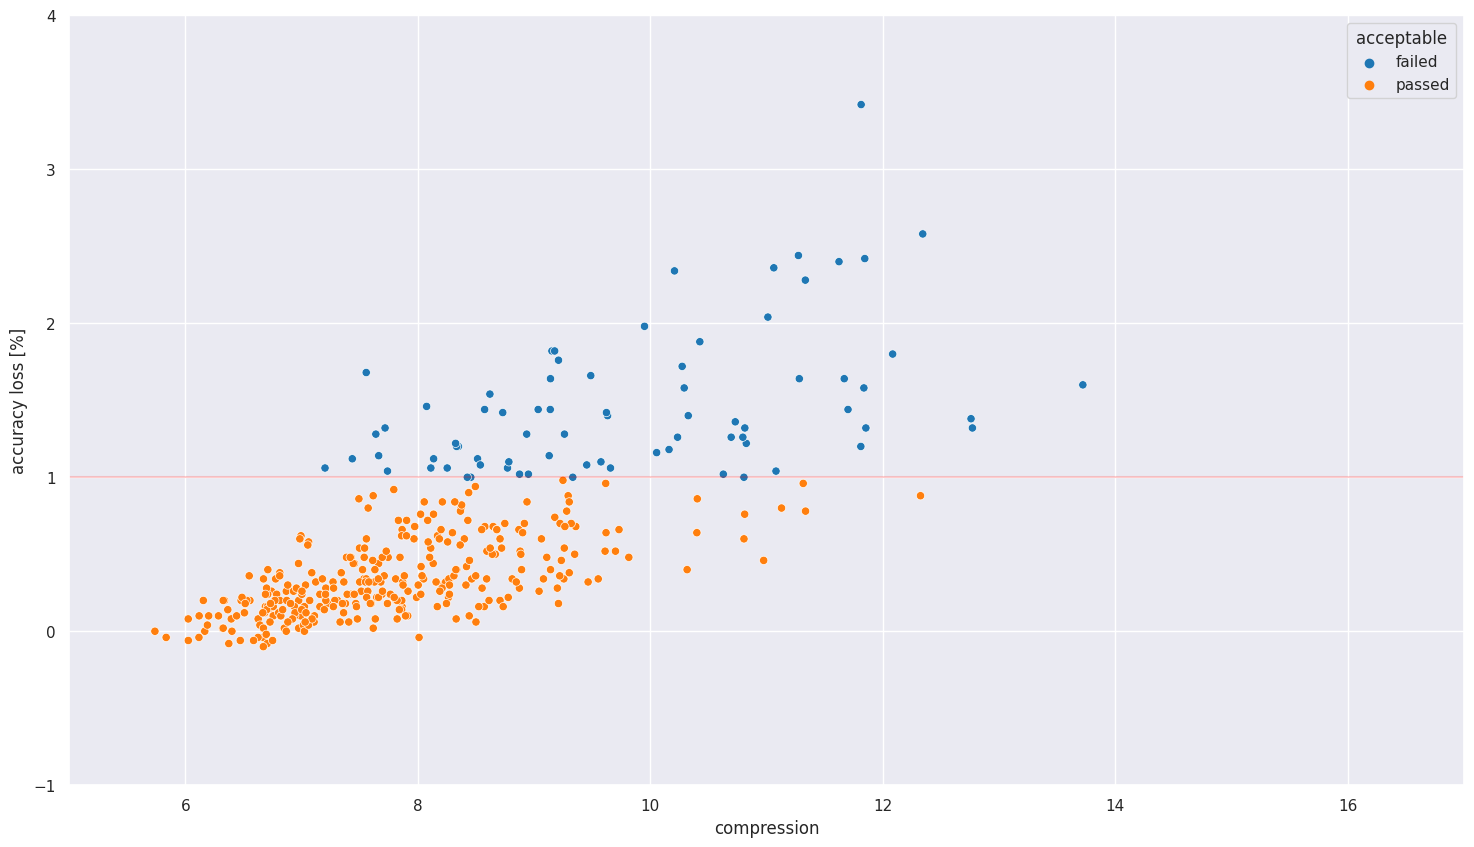

In [10]:
plot_alcr(rnd_data)